Install packages

In [ ]:
!pip install -q 'openvino-dev>=2023.0.0' 'nncf>=2.5.0'
!pip install -q 'ultralytics==8.0.43' onnx

Import required utility functions

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from pathlib import Path

Detect the screens of tv, laptops, and phones in the picture and paint in black the segmented masks for privacy in the office

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.43 🚀 Python-3.7.5 torch-1.13.1+cpu CPU
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs

image 1/1 /home/asar/Documents/VirtualEnvironmentIntel/openvino_notebooks/notebooks/230-yolov8-optimization/data/office4.jpg: 448x640 7 tvs, 6 laptops, 75.3ms
Speed: 0.5ms preprocess, 75.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)


There are  13  screens to remove


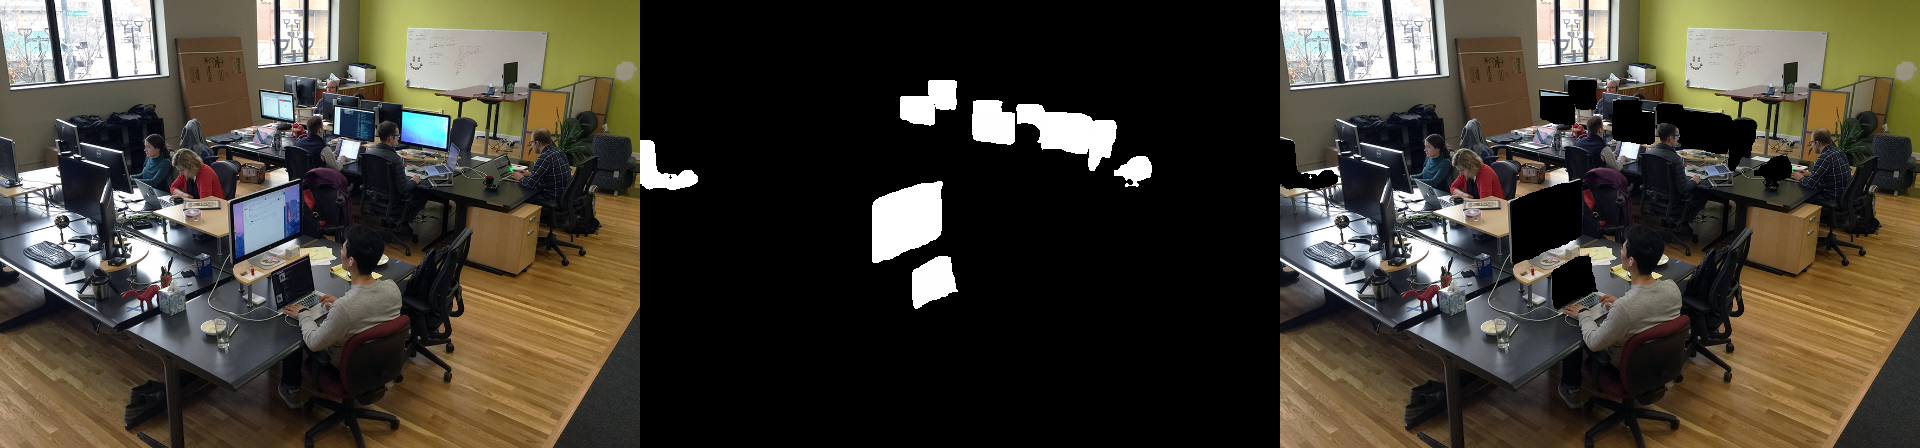

In [29]:
path_of_image = "./data/office4.jpg"
models_dir = Path('./models')
models_dir.mkdir(exist_ok=True)
IMAGE_PATH = Path(path_of_image)
SEG_MODEL_NAME = "yolov8n-seg"
seg_model = YOLO(models_dir / f'{SEG_MODEL_NAME}.pt')

# Only detect classes: 62-tv, 63-laptop, 67-cellphone
results = seg_model.predict(IMAGE_PATH, classes=[62,63,67], show=True, hide_labels=True, hide_conf=True)
result = results[0]

# Get the required information about the mask
mask_data = list((result.masks.masks).size())
detected_screens = mask_data[0]
mask_shape_h = mask_data[1]
mask_shape_w = mask_data[2]

print("There are ", str(detected_screens), " screens to remove")

# Resize image to mask
inputImg = cv2.imread(path_of_image)
inputImg_resized = cv2.resize(inputImg, (mask_shape_w, mask_shape_h))
#cv2_imshow(inputImg_resized)

# Put together all the segmented masks for the detected screens to obtain a mask for all the screens in the picture
mask = np.zeros([mask_shape_h, mask_shape_w])
for i in range(len(result.masks.masks)):
    mask = mask + result.masks.masks[i].numpy()
final_mask = (mask * 255).astype("uint8")
#cv2_imshow(final_mask)

# Apply mask to a copy of the original image
masked_result = inputImg_resized.copy()
masked_result[final_mask!=0] = (0,0,0)
#cv2_imshow(masked_result)

# Display the original picture, the mask, and the masked outcome
final_mask_3_channels = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)
numpy_horizontal = np.hstack((inputImg_resized, final_mask_3_channels, masked_result))
cv2_imshow(numpy_horizontal)
